In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import warnings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scipy.stats import randint,uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1.数据读取

In [5]:
df=pd.read_csv('factory_sensor_simulator_2040.csv')
df.head()

,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,...,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,5,True,3,162.0,False,NaN,NaN,NaN,NaN,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,2,True,4,147.0,False,NaN,NaN,40.92,NaN,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,1,True,6,0.0,True,NaN,NaN,NaN,NaN,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,1,False,4,161.0,False,NaN,NaN,NaN,NaN,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,2,False,1,765.0,False,NaN,NaN,NaN,NaN,0


# 2.数据集信息概况

In [6]:
df.columns

Index(['Machine_ID', 'Machine_Type', 'Installation_Year', 'Operational_Hours',
       'Temperature_C', 'Vibration_mms', 'Sound_dB', 'Oil_Level_pct',
       'Coolant_Level_pct', 'Power_Consumption_kW',
       'Last_Maintenance_Days_Ago', 'Maintenance_History_Count',
       'Failure_History_Count', 'AI_Supervision', 'Error_Codes_Last_30_Days',
       'Remaining_Useful_Life_days', 'Failure_Within_7_Days',
       'Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min',
       'Heat_Index', 'AI_Override_Events'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Machine_ID                  500000 non-null  object 
 1   Machine_Type                500000 non-null  object 
 2   Installation_Year           500000 non-null  int64  
 3   Operational_Hours           500000 non-null  int64  
 4   Temperature_C               500000 non-null  float64
 5   Vibration_mms               500000 non-null  float64
 6   Sound_dB                    500000 non-null  float64
 7   Oil_Level_pct               500000 non-null  float64
 8   Coolant_Level_pct           500000 non-null  float64
 9   Power_Consumption_kW        500000 non-null  float64
 10  Last_Maintenance_Days_Ago   500000 non-null  int64  
 11  Maintenance_History_Count   500000 non-null  int64  
 12  Failure_History_Count       500000 non-null  int64  
 13  AI_Supervision

In [8]:
#数据抽样
sample_fraction=0.2
df_sampled=df.sample(frac=sample_fraction,random_state=42)
print(f"抽样后数据: {len(df_sampled)} 行 ({sample_fraction*100}% 数据)")

抽样后数据: 100000 行 (20.0% 数据)


In [9]:
#缺失值分析
df.isnull().sum().sort_values(ascending=False).head()

Laser_Intensity           484844
Hydraulic_Pressure_bar    469660
Heat_Index                454786
Coolant_Flow_L_min        454376
Machine_ID                     0
dtype: int64

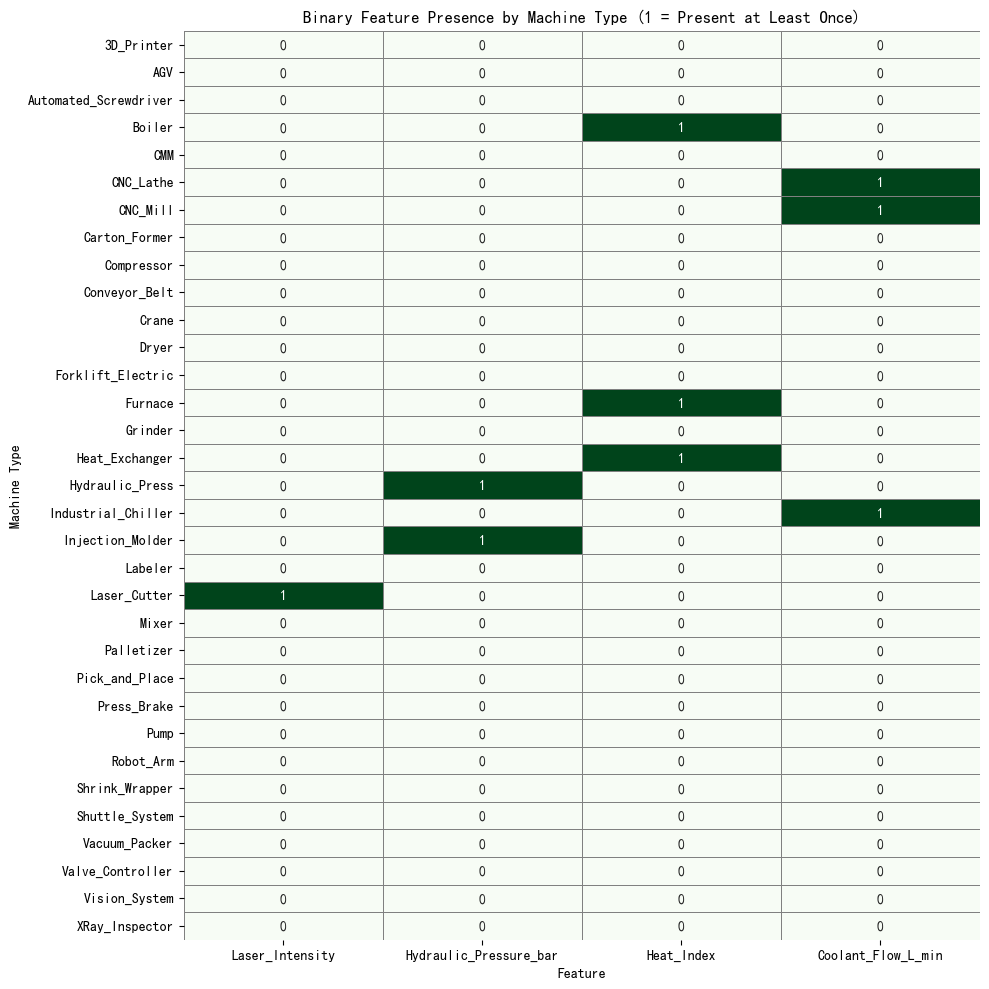

In [19]:
features_to_check=['Laser_Intensity','Hydraulic_Pressure_bar','Heat_Index','Coolant_Flow_L_min']
presence_matrix=df.groupby('Machine_Type')[features_to_check].apply(lambda x :x.notnull().any().astype(int))
plt.figure(figsize=(10,10))
sns.heatmap(presence_matrix,annot=True,cmap='Greens',cbar=False,linewidth=0.5,linecolor='gray')
plt.title("Binary Feature Presence by Machine Type (1 = Present at Least Once)")
plt.xlabel('Feature')
plt.ylabel('Machine Type')
plt.tight_layout()
plt.show()

In [21]:
# columns_to_drop=['Laser_Intensity','Hydraulic_Pressure_bar','Heat_Index','Coolant_Flow_L_min']
columns_to_drop=[]

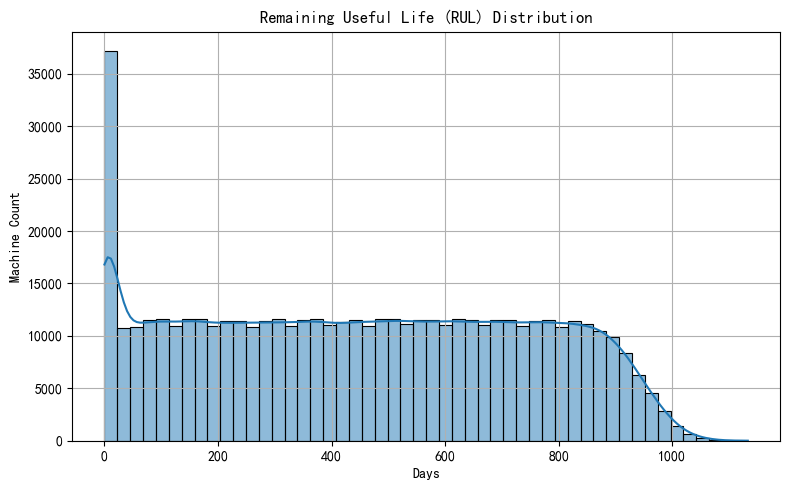

In [27]:
# 直方图可视化目标变量 Remaining_Useful_Life_days 的分布
plt.figure(figsize=(8,5))
sns.histplot(df['Remaining_Useful_Life_days'],bins=50,kde=True)
plt.title('Remaining Useful Life (RUL) Distribution')
plt.xlabel('Days')
plt.ylabel('Machine Count')
plt.grid(True)
plt.tight_layout()
plt.show()

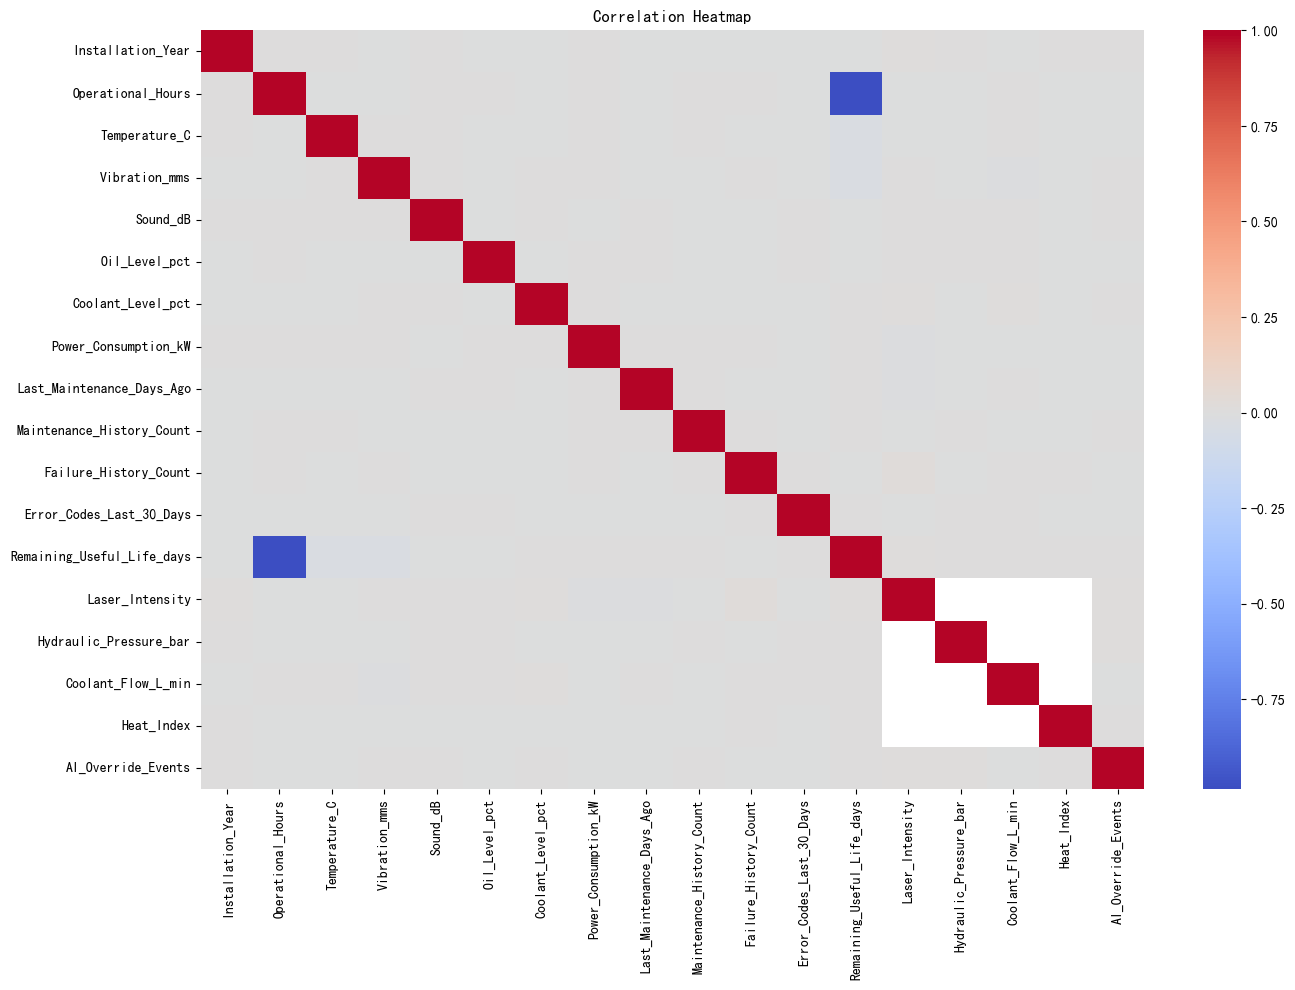

In [28]:
num_features=df.select_dtypes(include=[np.number])
if 'Failure_Within_7_Days' in num_features.columns:
    num_features=num_features.drop(columns=['Failure_Within_7_Days'])
plt.figure(figsize=(14,10))
sns.heatmap(num_features.corr(),cmap='coolwarm',center=0,annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 3.数据预处理

In [23]:
#数据预处理
def preprocess_data(df,columns_to_drop):
    current_year = 2025
    df_processed = df.copy()
    #删除不需要地列
    cols_to_drop=columns_to_drop+['Machine_ID', 'Failure_Within_7_Days']
    df_processed = df_processed.drop([col for col in cols_to_drop if col in df_processed.columns], axis=1)
    df_processed=df_processed[df_processed['Installation_Year'] <= current_year].copy()
    #特征工程
    df_processed['Has_Laser']=df_processed['Laser_Intensity'].apply(lambda x:1 if pd.notnull(x) else 0)
    df_processed['Has_Hydraulics']=df_processed['Hydraulic_Pressure_bar'].apply(lambda x:1 if pd.notnull(x) else 0)
    df_processed['Has_Coolant']=df_processed['Coolant_Flow_L_min'].apply(lambda x:1 if pd.notnull(x) else 0)
    df_processed['Has_Heat_Index'] = df_processed['Heat_Index'].apply(lambda x: 1 if pd.notnull(x) else 0)
    df_processed['Machine_Age'] = current_year - df_processed['Installation_Year']
    df_processed['Daily_Operation_Hours'] = df_processed['Operational_Hours'] / (df_processed['Machine_Age'] * 365).clip(1)
    df_processed['Hours_Since_Maintenance'] = df_processed['Last_Maintenance_Days_Ago'] * 24
    # 定义特征和目标
    X = df_processed.drop(['Remaining_Useful_Life_days'], axis=1)
    y = df_processed['Remaining_Useful_Life_days']
    # 定义数值和类别特征
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    print(f"数值特征: {len(numeric_features)} 个")
    print(f"类别特征: {len(categorical_features)} 个")
    print(f"总特征数: {X.shape[1]}")
    
    return X, y, numeric_features, categorical_features


In [25]:
X, y, numeric_features, categorical_features = preprocess_data(df_sampled, columns_to_drop)

数值特征: 24 个
类别特征: 1 个
总特征数: 26


In [31]:
X.head()

,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,...,Coolant_Flow_L_min,Heat_Index,AI_Override_Events,Has_Laser,Has_Hydraulics,Has_Coolant,Has_Heat_Index,Machine_Age,Daily_Operation_Hours,Hours_Since_Maintenance
104241,CMM,2001,51857,88.97,13.67,73.75,52.20,82.24,67.50,194,...,NaN,NaN,0,0,0,0,0,24,5.919749,4656
140199,Injection_Molder,2012,79314,67.29,13.36,71.03,68.67,74.20,315.53,255,...,NaN,NaN,3,0,1,0,0,13,16.715279,6120
408697,Automated_Screwdriver,2004,16505,64.35,8.67,78.40,73.28,20.48,99.61,233,...,NaN,NaN,1,0,0,0,0,21,2.153294,5592
163280,Press_Brake,2010,38918,61.03,10.30,101.85,64.17,42.71,324.34,211,...,NaN,NaN,0,0,0,0,0,15,7.108311,5064
215758,Press_Brake,2001,61576,62.98,11.79,88.85,84.72,81.57,129.63,343,...,NaN,NaN,0,0,0,0,0,24,7.029224,8232


In [33]:
X['Installation_Year'].max()

2025

In [35]:
X.shape

(63585, 26)

In [37]:
y

104241    447.0
140199    160.0
408697    720.0
163280    561.0
215758    310.0
          ...  
226735    549.0
66361     727.0
497228    236.0
152728    296.0
240408    619.0
Name: Remaining_Useful_Life_days, Length: 63585, dtype: float64

In [39]:
#管道预处理
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 用中位数填充缺失值
    ('scaler', StandardScaler())  # 标准化数据
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 用众数填充缺失值
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # 独热编码
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [41]:
#数据划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n数据拆分:")
print(f"训练集: {X_train.shape[0]} 行")
print(f"测试集: {X_test.shape[0]} 行")
print(f"目标变量范围: {y.min():.0f} - {y.max():.0f} 天")


数据拆分:
训练集: 50868 行
测试集: 12717 行
目标变量范围: 0 - 1128 天


In [43]:
# 预处理训练数据
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [45]:
#定义评估函数
def evaluate_model(model,X_test,y_test,model_name):
    y_pred=model.predict(X_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    mae=mean_absolute_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    mape=np.mean(np.abs((y_test-y_pred)/np.clip(np.abs(y_test),1,None)))*100
    return{
        'RMSE':rmse,
        'MAE':mae,
        'R²':r2,
        'MAPE':mape,
        'predictions':y_pred
    }
def print_evaluation(results, model_name):
    """打印评估结果"""
    print(f"\n{model_name} 性能:")
    print(f"  RMSE: {results['RMSE']:.2f} 天")
    print(f"  MAE: {results['MAE']:.2f} 天")
    print(f"  R²: {results['R²']:.4f}")
    print(f"  MAPE: {results['MAPE']:.2f}%")
    return results['RMSE']

# 4.模型训练

## 4.1基准模型训练

In [86]:
#基准模型训练
base_models={
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1),
    'AdaBoost':AdaBoostRegressor(),
    'GBR':GradientBoostingRegressor()
}

In [88]:
base_results={}
base_predictions={}
for name,model in base_models.items():
    model.fit(X_train_processed, y_train)
    results = evaluate_model(model, X_test_processed, y_test, name)
    rmse = print_evaluation(results, name)
    
    base_results[name] = results
    base_results[name]['model'] = model
    base_predictions[name] = results['predictions']


RandomForest 性能:
  RMSE: 49.50 天
  MAE: 39.13 天
  R²: 0.9705
  MAPE: 162.69%

XGBoost 性能:
  RMSE: 49.79 天
  MAE: 39.45 天
  R²: 0.9702
  MAPE: 160.84%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 57
[LightGBM] [Info] Start training from score 453.772332

LightGBM 性能:
  RMSE: 48.78 天
  MAE: 38.58 天
  R²: 0.9714
  MAPE: 159.12%

AdaBoost 性能:
  RMSE: 53.49 天
  MAE: 43.44 天
  R²: 0.9656
  MAPE: 471.68%

GBR 性能:
  RMSE: 48.66 天
  MAE: 38.51 天
  R²: 0.9715
  MAPE: 162.13%


In [419]:
# #参数调优
# lgb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [31, 63, 127],
#     'max_depth': [5, 7, 9],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# lgb_grid_search = GridSearchCV(
#     LGBMRegressor(random_state=42, n_jobs=-1),
#     lgb_param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )

# lgb_grid_search.fit(X_train_processed, y_train)

# print(f"最佳参数: {lgb_random_search.best_params_}")
# print(f"最佳交叉验证分数: {-lgb_random_search.best_score_:.2f}")
# # 使用调优后的模型
# lgb_tuned = lgb_grid_search.best_estimator_
# lgb_tuned.fit(X_train_processed, y_train)
# lgb_tuned_results = evaluate_model(lgb_tuned, X_test_processed, y_test, "LightGBM调优")
# lgb_tuned_rmse = print_evaluation(lgb_tuned_results, "LightGBM调优后")

## 4.2参数调优

### 4.2.1随机森林

In [74]:
# RandomForest 参数调优
rf_param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [5,10, 20],
    'min_samples_split': [2,3, 5]
}

rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_processed, y_train)
print(f"RandomForest 最佳参数: {rf_grid_search.best_params_}")
rf_tuned = rf_grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
RandomForest 最佳参数: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [76]:
-rf_grid_search.best_score_

48.65081725208571

### 4.2.2XGBoost

In [52]:
# XGBoost 参数调优
xgb_param_grid = {
    'n_estimators': [50,100, 200],
    'learning_rate': [0.01,0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train_processed, y_train)
print(f"XGBoost 最佳参数: {xgb_grid_search.best_params_}")
xgb_tuned = xgb_grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
XGBoost 最佳参数: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [53]:
-xgb_grid_search.best_score_

48.30051995788548

### 4.2.3LightGBM

In [54]:
# LightGBM 参数调优
lgb_param_grid = {
    'n_estimators': [50,100, 200],
    'learning_rate': [0.01,0.05, 0.1],
    'num_leaves': [31, 63],
    'max_depth': [5, 7]
}

lgb_grid_search = GridSearchCV(
    LGBMRegressor(force_col_wise=True,random_state=42, n_jobs=-1),
    lgb_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgb_grid_search.fit(X_train_processed, y_train)
print(f"LightGBM 最佳参数: {lgb_grid_search.best_params_}")
lgb_tuned = lgb_grid_search.best_estimator_

[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 57
[LightGBM] [Info] Start training from score 453.772332
LightGBM 最佳参数: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 31}


In [55]:
-lgb_grid_search.best_score_

48.42903408286305

### 4.2.4 AdaBoostRegressor

In [105]:
#AdaBoostRegressor参数调优
ada_grid_params={
    'n_estimators':[50,100,200],
    'learning_rate':[0.01,0.1,0.5,1.0],
    'loss':['linear','square','exponential']
}
ada_grid_search=GridSearchCV(
    estimator=AdaBoostRegressor(),
    param_grid=ada_grid_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
ada_grid_search.fit(X_train_processed, y_train)
print("最佳参数:", ada_grid_search.best_params_)
print("最佳得分:", ada_grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳参数: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
最佳得分: -51.518909864536866


In [106]:
ada_tuned = ada_grid_search.best_estimator_

### 4.2.5GradientBoostingRegressor

In [100]:
#GradientBoostingRegressor参数调优
gbr_grid_params={
    'n_estimators':[100,200],
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[3,4,5],
    'min_samples_split':[2,5,10],
    'subsample':[0.8,0.9,1.0]
}
gbr_grid_search=GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gbr_grid_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gbr_grid_search.fit(X_train_processed,y_train)
print('最佳参数:',gbr_grid_search.best_params_)
print('最佳得分:',gbr_grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
最佳参数: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
最佳得分: -48.265897222365155


In [107]:
gbr_tuned = gbr_grid_search.best_estimator_

## 4.3模型总结

In [117]:
rf_tuned.fit(X_train_processed, y_train)
rf_tuned_results = evaluate_model(rf_tuned, X_test_processed, y_test, "RandomForest调优")
rf_tuned_rmse = print_evaluation(rf_tuned_results, "RandomForest调优后")

xgb_tuned.fit(X_train_processed, y_train)
xgb_tuned_results = evaluate_model(xgb_tuned, X_test_processed, y_test, "XGBoost调优")
xgb_tuned_rmse = print_evaluation(xgb_tuned_results, "XGBoost调优后")

lgb_tuned.fit(X_train_processed, y_train)
lgb_tuned_results = evaluate_model(lgb_tuned, X_test_processed, y_test, "LightGBM调优")
lgb_tuned_rmse = print_evaluation(lgb_tuned_results, "LightGBM调优后")

gbr_tuned.fit(X_train_processed, y_train)
gbr_tuned_results = evaluate_model(gbr_tuned, X_test_processed, y_test, "GBR调优")
gbr_tuned_rmse = print_evaluation(gbr_tuned_results, "GBR调优后")

ada_tuned.fit(X_train_processed, y_train)
ada_tuned_results = evaluate_model(ada_tuned, X_test_processed, y_test, "AdaBoost调优")
ada_tuned_rmse = print_evaluation(ada_tuned_results, "AdaBoost调优后")
# 确保这些变量在后续代码中可用
tuned_results = {
    'RandomForest': rf_tuned_results,
    'XGBoost': xgb_tuned_results,
    'LightGBM': lgb_tuned_results,
    'GBR':gbr_tuned_results,
    'AdaBoost': ada_tuned_results
}

tuned_models = {
    'RandomForest': rf_tuned,
    'XGBoost': xgb_tuned,
    'LightGBM': lgb_tuned,
    'GBR':gbr_tuned,
    'AdaBoost': ada_tuned
}

tuned_predictions = {
    'RandomForest': rf_tuned_results['predictions'],
    'XGBoost': xgb_tuned_results['predictions'],
    'LightGBM': lgb_tuned_results['predictions'],
    'GBR': gbr_tuned_results['predictions'],
    'AdaBoost': ada_tuned_results['predictions']
}


RandomForest调优后 性能:
  RMSE: 48.90 天
  MAE: 38.66 天
  R²: 0.9712
  MAPE: 157.22%

XGBoost调优后 性能:
  RMSE: 48.63 天
  MAE: 38.47 天
  R²: 0.9715
  MAPE: 161.42%
[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 57
[LightGBM] [Info] Start training from score 453.772332

LightGBM调优后 性能:
  RMSE: 48.73 天
  MAE: 38.67 天
  R²: 0.9714
  MAPE: 176.26%

GBR调优后 性能:
  RMSE: 48.62 天
  MAE: 38.46 天
  R²: 0.9716
  MAPE: 162.22%

AdaBoost调优后 性能:
  RMSE: 51.92 天
  MAE: 42.00 天
  R²: 0.9676
  MAPE: 356.46%


# 5.模型融合

## 5.1投票回归器

In [160]:
#  投票回归器
voting_regressor = VotingRegressor([
    ('rf_tuned', rf_tuned),
    ('xgb_tuned', xgb_tuned),
    ('lgb_tuned', lgb_tuned),
    ('gbr_tuned', gbr_tuned),
    ('ada_tuned', ada_tuned)
])

voting_regressor.fit(X_train_processed, y_train)
voting_results = evaluate_model(voting_regressor, X_test_processed, y_test, "投票融合")
voting_rmse = print_evaluation(voting_results, "投票融合")

[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 57
[LightGBM] [Info] Start training from score 453.772332

投票融合 性能:
  RMSE: 48.83 天
  MAE: 38.91 天
  R²: 0.9713
  MAPE: 202.94%


## 5.2 Stacking回归器

In [162]:
#  Stacking回归器
print("\n训练Stacking回归器...")
stacking_regressor = StackingRegressor([
    ('rf_tuned', rf_tuned),
    ('xgb_tuned', xgb_tuned),
    ('lgb_tuned', lgb_tuned),
    ('gbr_tuned', gbr_tuned),
    ('ada_tuned', ada_tuned)
], final_estimator=LinearRegression(), cv=3)

stacking_regressor.fit(X_train_processed, y_train)
stacking_results = evaluate_model(stacking_regressor, X_test_processed, y_test, "Stacking融合")
stacking_rmse = print_evaluation(stacking_results, "Stacking融合")


训练Stacking回归器...
[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 57
[LightGBM] [Info] Start training from score 453.772332
[LightGBM] [Info] Total Bins 3742
[LightGBM] [Info] Number of data points in the train set: 33912, number of used features: 57
[LightGBM] [Info] Start training from score 453.062485
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 33912, number of used features: 57
[LightGBM] [Info] Start training from score 453.961430
[LightGBM] [Info] Total Bins 3743
[LightGBM] [Info] Number of data points in the train set: 33912, number of used features: 57
[LightGBM] [Info] Start training from score 454.293082

Stacking融合 性能:
  RMSE: 48.60 天
  MAE: 38.41 天
  R²: 0.9716
  MAPE: 155.70%


## 5.3加权平均融合

In [164]:
# 加权平均融合
weights = {
    'RandomForest_tuned': 0.2,
    'XGBoost_tuned': 0.2,
    'LightGBM_tuned': 0.2,
    'AdaBoost_tuned':0.2,
    'GradientBoosting':0.2
}

rf_tuned_predictions = rf_tuned.predict(X_test_processed)
xgb_tuned_predictions = xgb_tuned.predict(X_test_processed)
lgb_tuned_predictions = lgb_tuned.predict(X_test_processed)
gbr_tuned_predictions = gbr_tuned.predict(X_test_processed)
ada_tuned_predictions = ada_tuned.predict(X_test_processed)

weighted_avg_predictions = (
    weights['RandomForest_tuned'] * rf_tuned_predictions +
    weights['XGBoost_tuned'] * xgb_tuned_predictions +
    weights['LightGBM_tuned'] * lgb_tuned_predictions+
    weights['GradientBoosting'] * gbr_tuned_predictions+
    weights['AdaBoost_tuned'] * ada_tuned_predictions
)

weighted_avg_rmse = np.sqrt(mean_squared_error(y_test, weighted_avg_predictions))
weighted_avg_r2 = r2_score(y_test, weighted_avg_predictions)
weighted_avg_mae = mean_absolute_error(y_test, weighted_avg_predictions)

print(f"\n加权平均融合性能:")
print(f"  RMSE: {weighted_avg_rmse:.2f} 天")
print(f"  R²: {weighted_avg_r2:.4f}")
print(f"  MAE: {weighted_avg_mae:.2f} 天")


加权平均融合性能:
  RMSE: 48.82 天
  R²: 0.9713
  MAE: 38.90 天


# 6总结分析

## 6.1模型性能比较

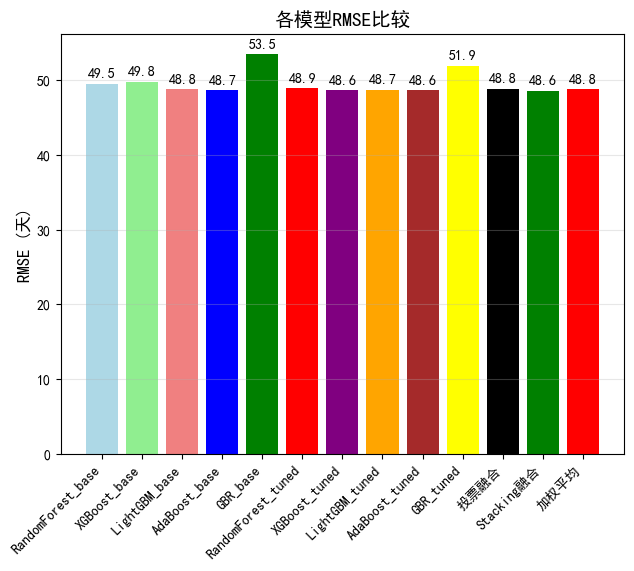

In [165]:
# 模型性能比较
plt.figure(figsize=(16, 12))

model_names = [
    'RandomForest_base', 'XGBoost_base', 'LightGBM_base','AdaBoost_base','GBR_base',
    'RandomForest_tuned', 'XGBoost_tuned', 'LightGBM_tuned','AdaBoost_tuned','GBR_tuned',
    '投票融合', 'Stacking融合', '加权平均'
]

rmse_values = [
    base_results['RandomForest']['RMSE'],
    base_results['XGBoost']['RMSE'],
    base_results['LightGBM']['RMSE'],
    base_results['GBR']['RMSE'],
    base_results['AdaBoost']['RMSE'],
    rf_tuned_results['RMSE'],
    xgb_tuned_results['RMSE'],
    lgb_tuned_results['RMSE'],
    gbr_tuned_results['RMSE'],
    ada_tuned_results['RMSE'],
    voting_results['RMSE'],
    stacking_results['RMSE'],
    weighted_avg_rmse
]

colors = ['lightblue', 'lightgreen', 'lightcoral', 
          'blue', 'green', 'red', 
          'purple', 'orange', 'brown','yellow','black','green','red']

plt.subplot(2, 2, 1)
bars = plt.bar(model_names, rmse_values, color=colors)
plt.title('各模型RMSE比较', fontsize=14, fontweight='bold')
plt.ylabel('RMSE (天)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, 
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

## 6.2预测 vs 实际值散点图（最佳模型）

Text(0.05, 0.95, 'R² = 0.972\nRMSE = 48.6')

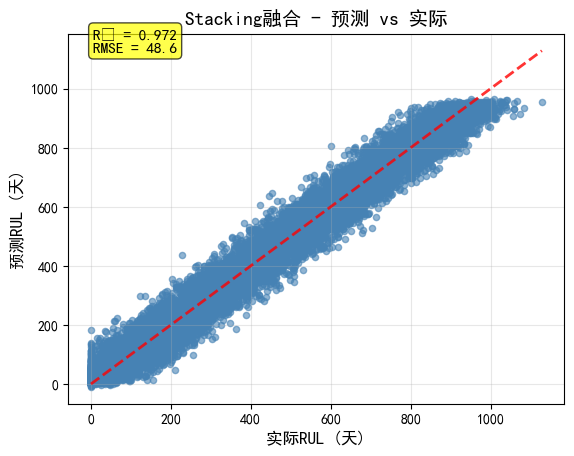

In [166]:
# 预测 vs 实际值散点图（最佳模型）
best_model_predictions = stacking_results['predictions']

plt.subplot(1, 1, 1)
plt.scatter(y_test, best_model_predictions, alpha=0.6, s=20, color='steelblue')
max_val = max(y_test.max(), best_model_predictions.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, alpha=0.8)
plt.xlabel('实际RUL (天)', fontsize=12)
plt.ylabel('预测RUL (天)', fontsize=12)
plt.title('Stacking融合 - 预测 vs 实际', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'R² = {stacking_results["R²"]:.3f}\nRMSE = {stacking_results["RMSE"]:.1f}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

## 6.3 误差分布图

Text(0.05, 0.95, '均值: 1.00\n标准差: 48.59')

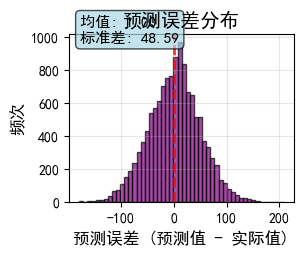

In [167]:
# 误差分布图
errors = best_model_predictions - y_test

plt.subplot(2, 2, 3)
n, bins, patches = plt.hist(errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.xlabel('预测误差 (预测值 - 实际值)', fontsize=12)
plt.ylabel('频次', fontsize=12)
plt.title('预测误差分布', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

mean_error = errors.mean()
std_error = errors.std()
plt.text(0.05, 0.95, f'均值: {mean_error:.2f}\n标准差: {std_error:.2f}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

In [171]:
print(f"RandomForest 特征重要性长度: {len(feature_importances['RandomForest'])}")
print(f"XGBoost 特征重要性长度: {len(feature_importances['XGBoost'])}")
print(f"LightGBM 特征重要性长度: {len(feature_importances['LightGBM'])}")
print(f"特征名称长度: {len(feature_names)}")

RandomForest 特征重要性长度: 57
XGBoost 特征重要性长度: 57
LightGBM 特征重要性长度: 57
特征名称长度: 57


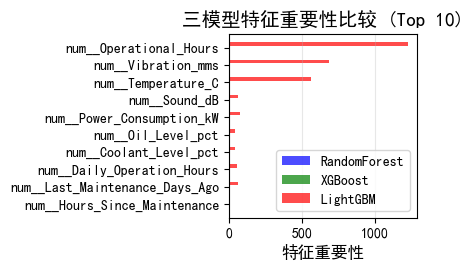

In [172]:
#特征重要性比较
plt.subplot(2, 2, 4)

# 获取三个模型的特征重要性
feature_importances = {
    'RandomForest': rf_tuned.feature_importances_,
    'XGBoost': xgb_tuned.feature_importances_,
    'LightGBM': lgb_tuned.feature_importances_
}

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

# 取RandomForest的前10个最重要特征
rf_indices = np.argsort(feature_importances['RandomForest'])[-10:]
x_pos = np.arange(len(rf_indices))

plt.barh(x_pos - 0.2, feature_importances['RandomForest'][rf_indices], 0.2, 
         label='RandomForest', color='blue', alpha=0.7)
plt.barh(x_pos, feature_importances['XGBoost'][rf_indices], 0.2, 
         label='XGBoost', color='green', alpha=0.7)
plt.barh(x_pos + 0.2, feature_importances['LightGBM'][rf_indices], 0.2, 
         label='LightGBM', color='red', alpha=0.7)

plt.yticks(x_pos, [feature_names[i] for i in rf_indices])
plt.xlabel('特征重要性', fontsize=12)
plt.title('三模型特征重要性比较 (Top 10)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6.4 模型性能总结

In [194]:
# 模型性能总结
print("\n" + "=" * 50)
print("模型性能总结")
print("=" * 50)

performance_summary = pd.DataFrame({
    '模型': model_names,
    'RMSE': rmse_values,
    'R²': [
        base_results['RandomForest']['R²'],
        base_results['XGBoost']['R²'],
        base_results['LightGBM']['R²'],
        base_results['GBR']['R²'],
        base_results['AdaBoost']['R²'],
        rf_tuned_results['R²'],
        xgb_tuned_results['R²'],
        lgb_tuned_results['R²'],
        gbr_tuned_results['R²'],
        ada_tuned_results['R²'],
        voting_results['R²'],
        stacking_results['R²'],
        weighted_avg_r2
    ],
    'MAE': [
        base_results['RandomForest']['MAE'],
        base_results['XGBoost']['MAE'],
        base_results['LightGBM']['MAE'],
        base_results['GBR']['MAE'],
        base_results['AdaBoost']['MAE'],
        rf_tuned_results['MAE'],
        xgb_tuned_results['MAE'],
        lgb_tuned_results['MAE'],
        gbr_tuned_results['MAE'],
        ada_tuned_results['MAE'],
        voting_results['MAE'],
        stacking_results['MAE'],
        weighted_avg_mae
    ]
}).sort_values('RMSE')

print("模型性能排名 (按RMSE升序):")
print(performance_summary.to_string(index=False))


模型性能总结
模型性能排名 (按RMSE升序):
                模型      RMSE       R²       MAE
        Stacking融合 48.602879 0.971570 38.411523
    AdaBoost_tuned 48.615588 0.971556 38.455165
     XGBoost_tuned 48.628350 0.971541 38.472281
     AdaBoost_base 48.658955 0.971505 38.511722
    LightGBM_tuned 48.732628 0.971418 38.669386
     LightGBM_base 48.782296 0.971360 38.584227
              加权平均 48.820848 0.971315 38.904606
              投票融合 48.826603 0.971308 38.914592
RandomForest_tuned 48.897510 0.971225 38.663330
 RandomForest_base 49.499511 0.970512 39.127654
      XGBoost_base 49.792416 0.970162 39.454964
         GBR_tuned 51.923798 0.967553 42.004208
          GBR_base 53.491856 0.965563 43.436759


In [174]:
# 模型保存
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

joblib.dump(preprocessor, f'preprocessor_{timestamp}.pkl')
joblib.dump(stacking_regressor, f'best_stacking_model_{timestamp}.pkl')
joblib.dump(rf_tuned, f'best_rf_model_{timestamp}.pkl')
joblib.dump(xgb_tuned, f'best_xgb_model_{timestamp}.pkl')
joblib.dump(lgb_tuned, f'best_lgb_model_{timestamp}.pkl')

print(f"✅ 预处理器保存为: preprocessor_{timestamp}.pkl")
print(f"✅ Stacking融合模型保存为: best_stacking_model_{timestamp}.pkl")
print(f"✅ RandomForest调优模型保存为: best_rf_model_{timestamp}.pkl")
print(f"✅ XGBoost调优模型保存为: best_xgb_model_{timestamp}.pkl")
print(f"✅ LightGBM调优模型保存为: best_lgb_model_{timestamp}.pkl")

✅ 预处理器保存为: preprocessor_20250902_145404.pkl
✅ Stacking融合模型保存为: best_stacking_model_20250902_145404.pkl
✅ RandomForest调优模型保存为: best_rf_model_20250902_145404.pkl
✅ XGBoost调优模型保存为: best_xgb_model_20250902_145404.pkl
✅ LightGBM调优模型保存为: best_lgb_model_20250902_145404.pkl


In [439]:
# m_id=data.pop('Machine_ID')

In [440]:
# data.head()

In [441]:
# fig=plt.figure(figsize=(4,6))
# sns.boxplot(data['Operational_Hours'],orient='v',width=0.5)

In [442]:
# #画箱式图
# column=data.columns.tolist()[1:21]
# fig=plt.figure(figsize=(20,40))
# for i in range(20):
#     plt.subplot(10,2,i+1)
#     sns.boxplot(data[column[i]],orient='v',width=0.5)
#     plt.ylabel(column[i],fontsize=10)
# plt.show()

In [443]:
# plt.figure(figsize=(10,5))
# ax=plt.subplot(1,2,1)
# sns.distplot(data['Operational_Hours'],fit=stats.norm)


In [444]:
# train_cols=6
# train_rows=len(data.columns)
# plt.figure(figsize=(4*train_col,4*train_rows))
# i=0
# for col in data.columns[1:]:
#     i+=1
#     ax=plt.subplot(train_rows,train_cols,i)
#     sns.distplot(data[col],fit=stats.norm)
#     i+=1
#     ax=plt.subplot(train_rows,train_cols,i)
#     res=stats.probplot(data[col],plot=plt)
# plt.show()

In [445]:
# # 画出相关性热力图
# # data_train1 = train_data.drop(['V5','V9','V11','V17','V22','V28'],axis=1)
# corr = data.iloc[:,1:].corr()
# ax = plt.subplots(figsize=(20, 16))#调整画布大小

# ax = sns.heatmap(corr, vmax=.8, square=True, annot=True)#画热力图   annot=True 显示系数

In [446]:
# k=10
# cols=corr.nlargest(k,'Remaining_Useful_Life_days')['Remaining_Useful_Life_days'].index
# plt.figure(figsize=(10,10))
# hm=sns.heatmap(data[cols].corr())
# plt.title(f'Top{k}特征相关性热力图')
# plt.show()